## Установка зависимостей

In [3]:
!pip install opendatasets

## Загрузка данных

In [ ]:
import opendatasets as datasets

data = datasets.download('https://www.kaggle.com/datasets/brandao/diabetes')

## Преобразование данных и  разведочный анализ

Импорт библиотек

In [ ]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

Загрузка и предварительная обработка данных (сокращение размера данных до 10 000)

In [ ]:
df = pd.read_csv('/content/diabetes/diabetic_data.csv')
df = df.sample(n=10000, random_state=3)
df = df.drop(['encounter_id', 'patient_nbr', 'payer_code', 'medical_specialty','diag_1', 'diag_2', 'diag_3'], axis=1)

Замена пропущенных значений

In [ ]:
df.replace('?', pd.NA, inplace=True)
df.replace('None', pd.NA, inplace=True)

Вывод первых строк DataFrame

In [ ]:
print(df.head())

Кодирование категориальных признаков

In [ ]:
label_encoders = {}
for column in ['race', 'gender', 'age', 'weight', 'change', 'diabetesMed', 'readmitted']:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column].astype(str))

Заполнение пропущенных значений для числовых столбцов

In [ ]:
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    df[column].fillna(df[column].mean(), inplace=True)

Преобразование и кодирование объектных столбцов

In [ ]:
for column in df.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения в столбце '{column}':")
    print(df[column].unique())
    print("\n")

unique_value_codes = {
    'No': 0,
    'Steady': 1,
    'Up': 2,
    'Down': 3,
    'Norm': 1,
    '>200': 200,
    '>300': 300,
    '>7': 7,
    '>8': 8
}

for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].map(unique_value_codes).fillna(0).astype(int)

Вывод информации о DataFrame после преобразований

In [ ]:
print(df.head())
print(df.info())

Визуализация данных с помощью гистограмм

In [ ]:
df.hist(bins=50, figsize=(20,15))
plt.show()

## Реализация K-means

In [6]:
import numpy as np
import pandas as pd

class Simple_KMeans:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self.labels = None

    def fit(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()

        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        for i in range(self.max_iter):
            distances = np.linalg.norm(X - self.centroids[:, np.newaxis], axis=2)
            self.labels = np.argmin(distances, axis=0)
            new_centroids = np.array([X[self.labels == j].mean(axis=0) if np.any(self.labels == j) else self.centroids[j] for j in range(self.n_clusters)])

            if np.all(np.linalg.norm(new_centroids - self.centroids, axis=1) < self.tol):
                break

            self.centroids = new_centroids
        return self

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        distances = np.linalg.norm(X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :], axis=2)
        return np.argmin(distances, axis=1)

## Обучение моделей кластеризации с использованием подбора гиперпараметров и сравнения качества моделей

  n_clusters  silhouette_score  davies_bouldin_score  calinski_harabasz_score  \
0          5          0.338353              0.784464             24187.558845   

   training_time  
0       1.345826  
  n_clusters  silhouette_score  davies_bouldin_score  calinski_harabasz_score  \
0          5          0.266783              1.058508              19781.49799   

   training_time  
0        0.97207  
  min_samples  silhouette_score  davies_bouldin_score  \
3          20         -0.315449              2.865202   

   calinski_harabasz_score  training_time  
3                58.174581       1.274909  


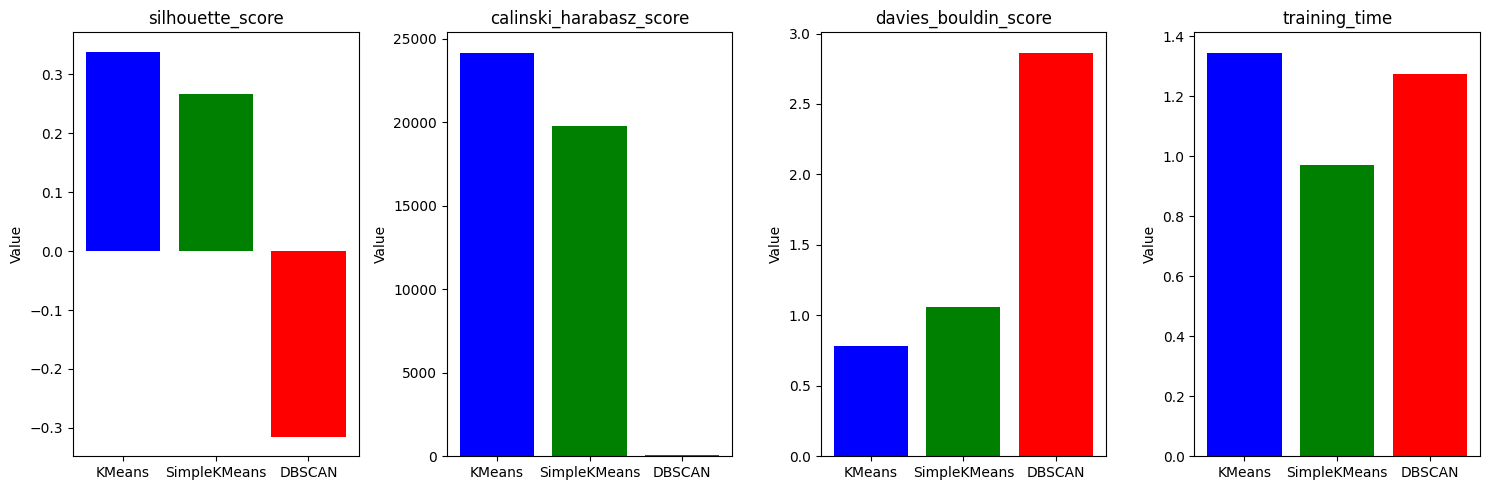

In [7]:
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
import time

def selection_hyperparam(algorithm, params, selection_param_name, selection_param_values):
    algorithm_df = pd.DataFrame(columns=[selection_param_name, 'silhouette_score', 'davies_bouldin_score', 'calinski_harabasz_score', 'training_time'])

    for selection_value in selection_param_values:
        start_time = time.time()
        if selection_param_name == 'n_clusters':
            model = algorithm(n_clusters=selection_value, **params).fit(df)
            labels = model.predict(df)
        elif selection_param_name == 'min_samples':
            model = algorithm(min_samples=selection_value, **params).fit(df)
            labels = model.labels_
        else:
            raise ValueError("Unsupported selection_param_name")

        end_time = time.time()

        training_time = end_time - start_time
        metric_silhouette_score = silhouette_score(df, labels)
        metric_davies_bouldin_score = davies_bouldin_score(df, labels)
        metric_calinski_harabasz_score = calinski_harabasz_score(df, labels)
        algorithm_df_row = {
            selection_param_name: selection_value,
            'silhouette_score': metric_silhouette_score,
            'davies_bouldin_score': metric_davies_bouldin_score,
            'calinski_harabasz_score': metric_calinski_harabasz_score,
            'training_time': training_time
        }
        algorithm_df = pd.concat([algorithm_df, pd.DataFrame([algorithm_df_row])], ignore_index=True)

    algorithm_df = algorithm_df.sort_values(by=['silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score'], ascending=[False, False, True])
    best_params = algorithm_df.head(1)
    return best_params


k_means_params = {'max_iter': 300, 'init': 'k-means++', 'random_state': 3, 'n_init': 10}
k_means_selection_values = range(5, 40, 8)
k_means_best = selection_hyperparam(KMeans, k_means_params, 'n_clusters', k_means_selection_values)
print(k_means_best)

simple_k_means_params = {'max_iter': 300, 'tol': 1e-4}
simple_k_means_selection_values = range(5, 40, 8)
simple_k_means_best = selection_hyperparam(Simple_KMeans, simple_k_means_params, 'n_clusters',
                                           simple_k_means_selection_values)
print(simple_k_means_best)

dbscan_params = {'eps': 4}
dbscan_selection_values = [5, 10, 15, 20]
dbscan_best = selection_hyperparam(DBSCAN, dbscan_params, 'min_samples', dbscan_selection_values)

print(dbscan_best)

k_means_values = k_means_best.iloc[0]
simple_k_means_values = simple_k_means_best.iloc[0]
dbscan_values = dbscan_best.iloc[0]

metrics = ['silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score', 'training_time']
algorithms = ['KMeans', 'SimpleKMeans', 'DBSCAN']

fig, axs = plt.subplots(1, len(metrics), figsize=(15, 5))

for idx, metric in enumerate(metrics):
    values = [k_means_values[metric], simple_k_means_values[metric], dbscan_values[metric]]
    axs[idx].bar(algorithms, values, color=['blue', 'green', 'red'])
    axs[idx].set_title(metric)
    axs[idx].set_ylabel('Value')

plt.tight_layout()
plt.show()



## Снижение размерности данных с помощью метода главных компонент PCA и анализа качества кластеризации при различном количестве главных компонент.

PCA с 2 компонентами:
KMeans метрики:
silhouette_score: 0.5710336136296583
calinski_harabasz_score: 68195.24483959602
davies_bouldin_score: 0.43815492248312504
SimpleKMeans метрики:
silhouette_score: 0.8861256179731121
calinski_harabasz_score: 10832.25716192153
davies_bouldin_score: 0.7618111831672815
DBSCAN метрики:
silhouette_score: 0.5430908120404765
calinski_harabasz_score: 42733.658946669035
davies_bouldin_score: 0.4722550024224022

PCA с 3 компонентами:
KMeans метрики:
silhouette_score: 0.4384738531037771
calinski_harabasz_score: 37525.07356158494
davies_bouldin_score: 0.6107203203031972
SimpleKMeans метрики:
silhouette_score: 0.5429756412028005
calinski_harabasz_score: 3828.5008772198435
davies_bouldin_score: 1.5201331444884225
DBSCAN метрики:
silhouette_score: 0.37851043959596314
calinski_harabasz_score: 28154.287555373012
davies_bouldin_score: 0.7727563675878386

PCA с 5 компонентами:
KMeans метрики:
silhouette_score: 0.38106486090564884
calinski_harabasz_score: 28569.33940261

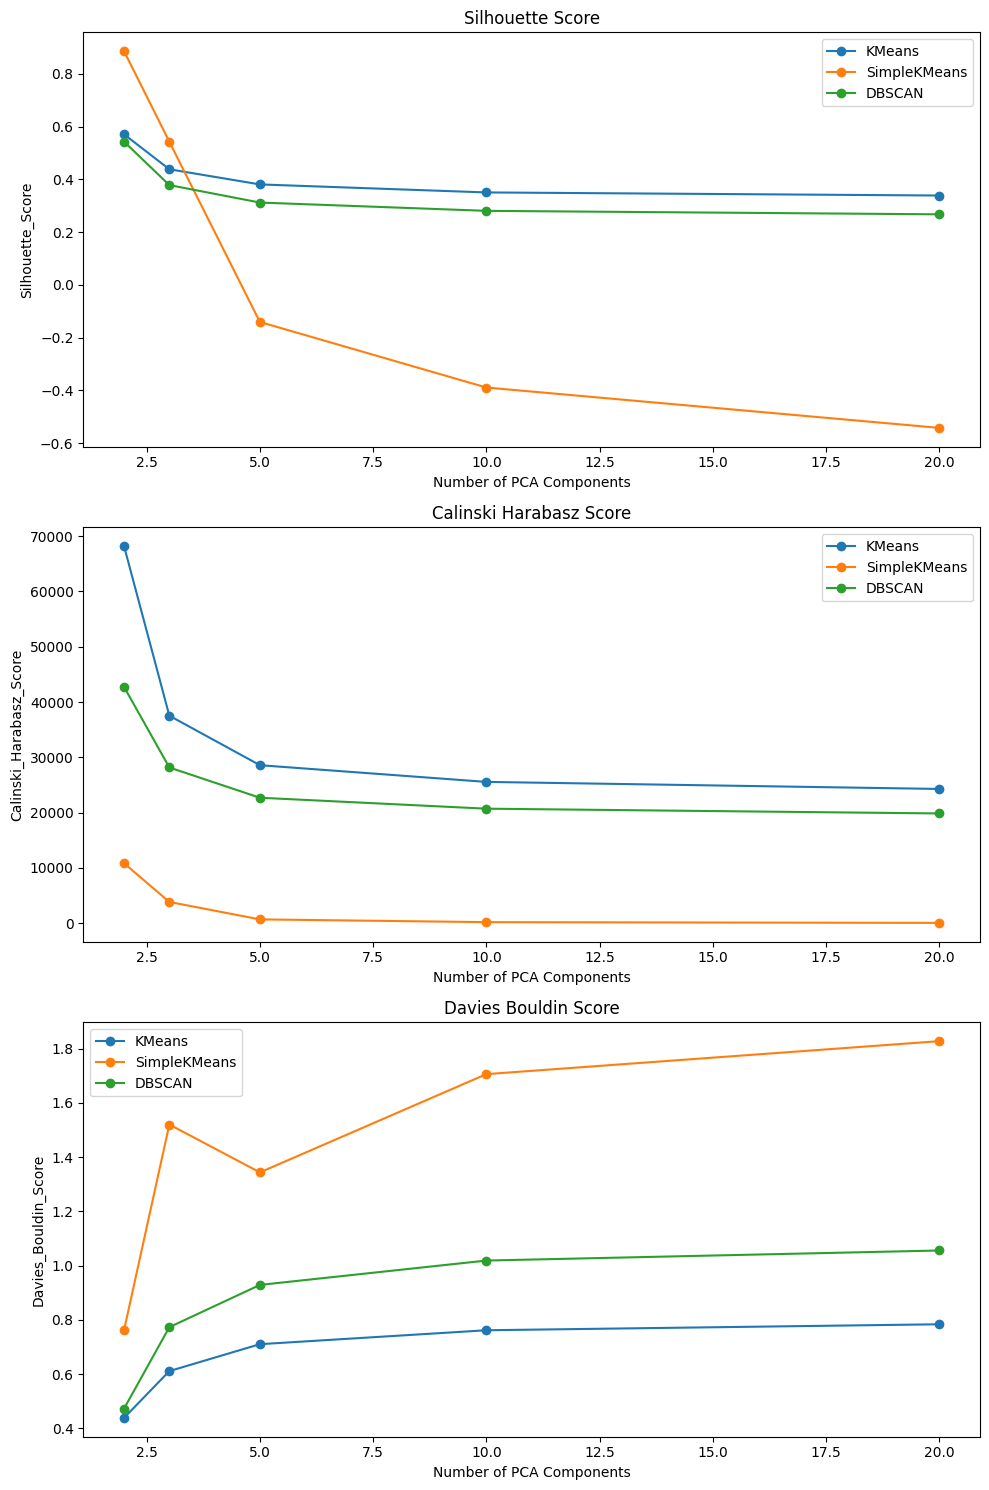

In [12]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

n_components_list = [2, 3, 5, 10, 20]
results = {}

for n_components in n_components_list:
    results[n_components] = {}
    pca = PCA(n_components=n_components)
    df_reduced = pca.fit_transform(df)

    kmeans = KMeans(n_clusters=5, max_iter=300, random_state=3, n_init=10)
    kmeans_labels = kmeans.fit_predict(df_reduced)

    dbscan = DBSCAN(eps=5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(df_reduced)

    simple_kmeans = Simple_KMeans(n_clusters=5, max_iter=300, tol=1e-4).fit(df_reduced)
    simple_kmeans_labels = simple_kmeans.predict(df_reduced)

    metrics = ['silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score']
    algorithms = ['KMeans', 'SimpleKMeans', 'DBSCAN']
    labels = [kmeans_labels, dbscan_labels, simple_kmeans_labels]
    for labels, name in zip(labels, algorithms):
        if len(set(labels)) > 1:
            silhouette = silhouette_score(df_reduced, labels)
            calinski = calinski_harabasz_score(df_reduced, labels)
            davies = davies_bouldin_score(df_reduced, labels)
        else:
            silhouette, calinski, davies = np.nan, np.nan, np.nan

        results[n_components][name] = {
            'silhouette_score': silhouette,
            'calinski_harabasz_score': calinski,
            'davies_bouldin_score': davies
        }

for n_components, algorithms_results in results.items():
    print(f"PCA с {n_components} компонентами:")
    for algorithm, metrics in algorithms_results.items():
        print(f"{algorithm} метрики:")
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name}: {metric_value}")
    print()

fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 15))

for idx, metric in enumerate(metrics):
    for algorithm in algorithms:
        x = []
        y = []
        for n_components, algorithms_results in results.items():
            if algorithm in algorithms_results:
                x.append(n_components)
                y.append(algorithms_results[algorithm][metric])
        axs[idx].plot(x, y, marker='o', label=algorithm)
    axs[idx].set_title(metric.replace('_', ' ').title())
    axs[idx].set_xlabel('Number of PCA Components')
    axs[idx].set_ylabel(metric.title())
    axs[idx].legend()

plt.tight_layout()
plt.show()

## Визуализация данных снижением размерности до 2 с помощью PCA и t-SNE

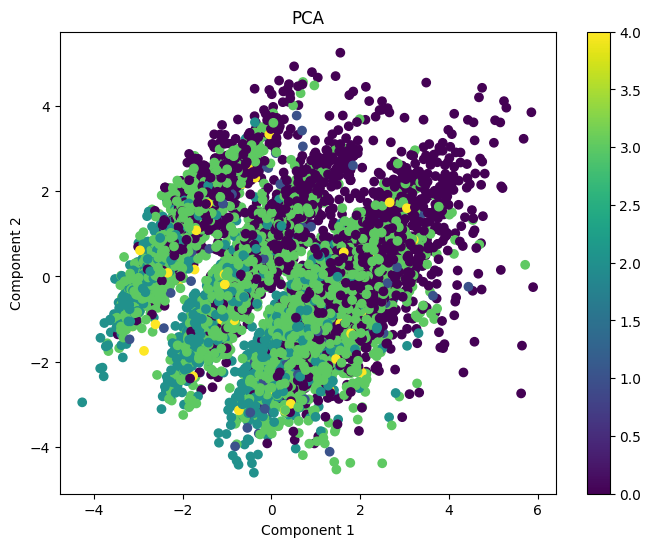

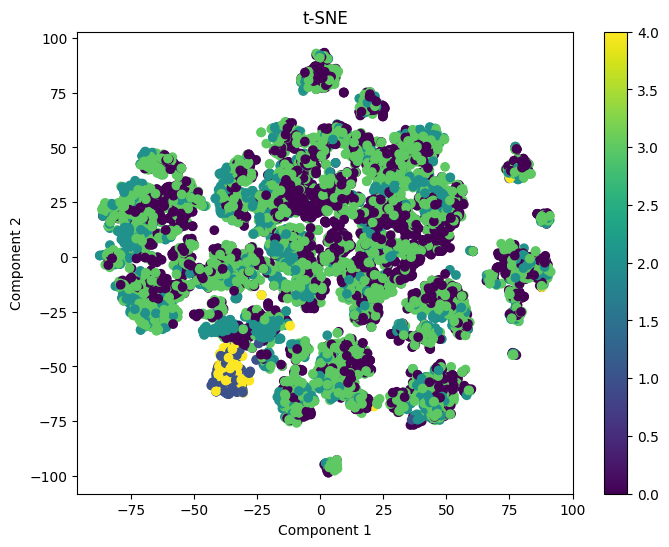

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df_scaled)


kmeans = KMeans(n_clusters=5, max_iter=300, random_state=3, n_init=10)
kmeans_labels = kmeans.fit_predict(df_reduced)

pca_2d = PCA(n_components=2)
df_pca_2d = pca_2d.fit_transform(df_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(df_pca_2d[:, 0], df_pca_2d[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
plt.title('PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.show()

pca_20d = PCA(n_components=20)
df_pca_20d = pca_20d.fit_transform(df_scaled)
tsne = TSNE(n_components=2, random_state=3)
df_tsne = tsne.fit_transform(df_pca_20d)
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
plt.title('t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.show()
